<a href="https://colab.research.google.com/github/Chinmoy430/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices/blob/main/Milestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/FitPulse Health Anomaly Detection from Fitness Devices"


/content/drive/MyDrive/FitPulse Health Anomaly Detection from Fitness Devices


In [ ]:
!ls

Milestone1  Milestone2	Milestone2_final.zip  Milestone3


In [ ]:
!mkdir Milestone3

mkdir: cannot create directory ‘Milestone3’: File exists


In [ ]:
!ls

Milestone1  Milestone2	Milestone2_final.zip  Milestone3


In [ ]:
%cd Milestone3/

/content/drive/MyDrive/FitPulse Health Anomaly Detection from Fitness Devices/Milestone3


In [ ]:
!ls

anomaly_detection


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os


In [ ]:
# Load cleaned dataset (from Milestone 1)
df = pd.read_csv("/content/drive/MyDrive/FitPulse Health Anomaly Detection from Fitness Devices/Milestone1/data/cleaned_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.tz_localize(None)

# Take at least 5 users
user_ids = df["Id"].unique()[:5]

df.head()


,Id,timestamp,heart_rate,steps,sleep
0,2022484408,2016-04-12 07:21:00,101.600000,17.0,0.0
1,2022484408,2016-04-12 07:22:00,87.888889,9.0,0.0
2,2022484408,2016-04-12 07:23:00,58.000000,0.0,0.0
3,2022484408,2016-04-12 07:24:00,58.000000,0.0,0.0
4,2022484408,2016-04-12 07:25:00,56.777778,0.0,0.0


In [ ]:
#Prophet is used to model expected heart rate trends and residuals are calculated as actual minus predicted values.
all_anomalies_hr = []

for uid in user_ids:
    user_df = df[df["Id"] == uid]

    hr = user_df[["timestamp", "heart_rate"]].dropna()
    hr = hr.rename(columns={"timestamp": "ds", "heart_rate": "y"})
    hr = hr.set_index("ds").resample("D").mean().reset_index()

    if len(hr) < 10:
        continue

    model = Prophet(daily_seasonality=True)
    model.fit(hr)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    merged = hr.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged["residual"] = merged["y"] - merged["yhat"]

    merged["user_id"] = uid
    all_anomalies_hr.append(merged)

hr_results = pd.concat(all_anomalies_hr)
hr_results.head()


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


,ds,y,yhat,residual,user_id
0,2016-04-12,74.172572,79.423829,-5.251257,2022484408
1,2016-04-13,78.787055,79.452958,-0.665903,2022484408
2,2016-04-14,70.727287,76.337747,-5.610459,2022484408
3,2016-04-15,78.755031,79.061849,-0.306817,2022484408
4,2016-04-16,74.542952,72.911843,1.631109,2022484408


In [ ]:
#Threshold-based Anomaly Detection
threshold_hr = 2 * hr_results["residual"].std()

hr_results["anomaly"] = abs(hr_results["residual"]) > threshold_hr
hr_results["label"] = hr_results["anomaly"].map(
    {True: "Anomalous", False: "Normal"}
)

hr_results[hr_results["anomaly"]].head()
#Residuals exceeding 2× standard deviation are marked as anomalies.

,ds,y,yhat,residual,user_id,anomaly,label
9,2016-04-21,86.368106,76.953056,9.415050,2022484408,True,Anomalous
16,2016-04-28,70.141705,77.561635,-7.419930,2022484408,True,Anomalous
0,2016-04-17,68.696508,76.064794,-7.368286,2026352035,True,Anomalous
8,2016-04-25,99.232268,83.960283,15.271985,2026352035,True,Anomalous
15,2016-05-02,83.155565,90.868836,-7.713271,2026352035,True,Anomalous


In [ ]:
#Anomaly Labeling
#Each data point is clearly labeled as Normal or Anomalous.
hr_results[["user_id", "ds", "y", "yhat", "residual", "label"]].head()


,user_id,ds,y,yhat,residual,label
0,2022484408,2016-04-12,74.172572,79.423829,-5.251257,Normal
1,2022484408,2016-04-13,78.787055,79.452958,-0.665903,Normal
2,2022484408,2016-04-14,70.727287,76.337747,-5.610459,Normal
3,2022484408,2016-04-15,78.755031,79.061849,-0.306817,Normal
4,2022484408,2016-04-16,74.542952,72.911843,1.631109,Normal


In [ ]:
os.makedirs("visualizations", exist_ok=True)


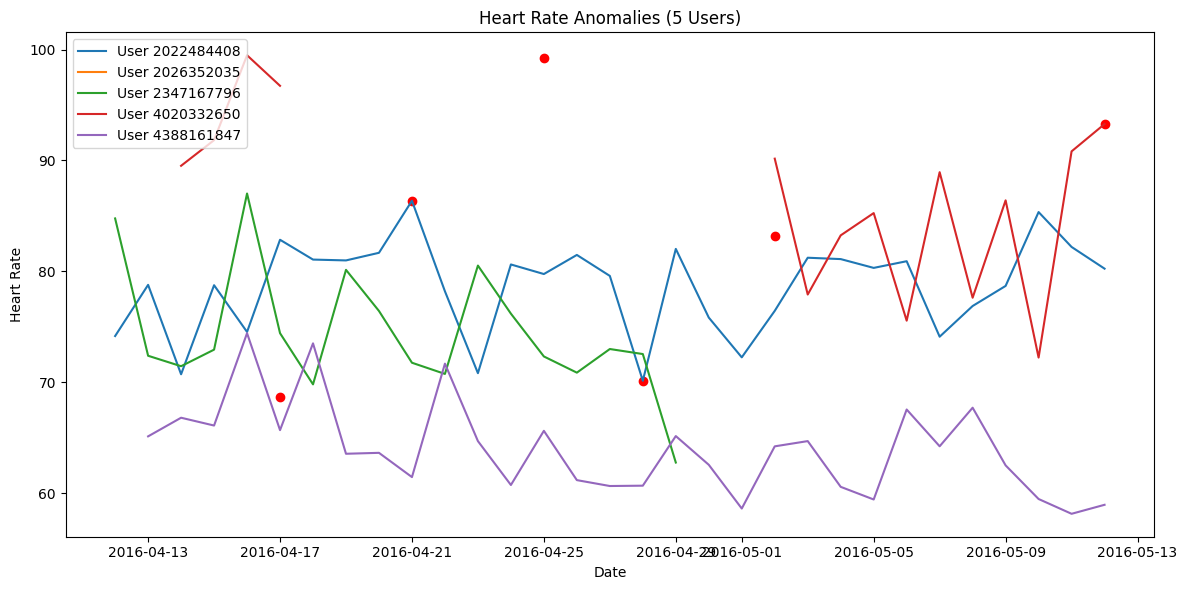

In [ ]:
#Heart rate anomalies for multiple users are highlighted in red on the time-series plot.
plt.figure(figsize=(12,6))

for uid in user_ids:
    user_data = hr_results[hr_results["user_id"] == uid]
    plt.plot(user_data["ds"], user_data["y"], label=f"User {uid}")

    anomalies = user_data[user_data["anomaly"]]
    plt.scatter(anomalies["ds"], anomalies["y"], color="red")

plt.title("Heart Rate Anomalies (5 Users)")
plt.xlabel("Date")
plt.ylabel("Heart Rate")
plt.legend()
plt.tight_layout()

plt.savefig("visualizations/heart_rate_anomalies.png")
plt.show()


In [ ]:
#Sleep Residuals & Anomalies (5 Users)
all_anomalies_sleep = []

for uid in user_ids:
    user_df = df[df["Id"] == uid]

    sleep = user_df[["timestamp", "sleep"]].dropna()
    sleep = sleep.rename(columns={"timestamp": "ds", "sleep": "y"})
    sleep = sleep.set_index("ds").resample("D").mean().reset_index()

    if len(sleep) < 10:
        continue

    model = Prophet(daily_seasonality=True)
    model.fit(sleep)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    merged = sleep.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged["residual"] = merged["y"] - merged["yhat"]

    merged["user_id"] = uid
    all_anomalies_sleep.append(merged)

sleep_results = pd.concat(all_anomalies_sleep)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


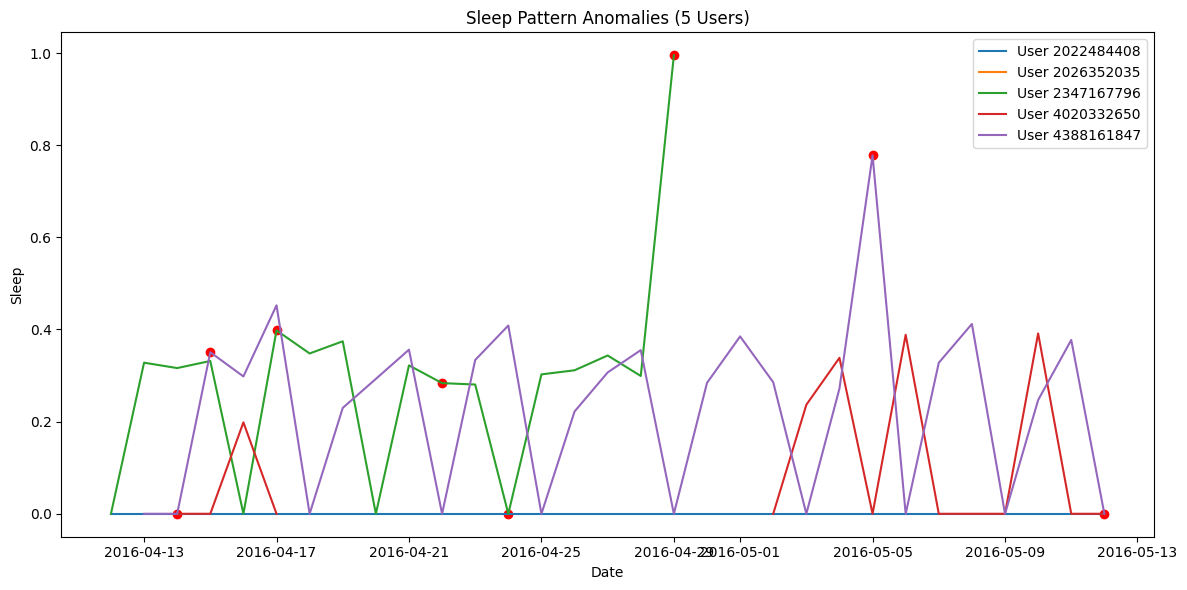

In [ ]:
#Abnormal sleep patterns across 5 users are visualized with anomaly markers.
threshold_sleep = 2 * sleep_results["residual"].std()
sleep_results["anomaly"] = abs(sleep_results["residual"]) > threshold_sleep

plt.figure(figsize=(12,6))

for uid in user_ids:
    user_data = sleep_results[sleep_results["user_id"] == uid]
    plt.plot(user_data["ds"], user_data["y"], label=f"User {uid}")

    anomalies = user_data[user_data["anomaly"]]
    plt.scatter(anomalies["ds"], anomalies["y"], color="red")

plt.title("Sleep Pattern Anomalies (5 Users)")
plt.xlabel("Date")
plt.ylabel("Sleep")
plt.legend()
plt.tight_layout()

plt.savefig("visualizations/sleep_anomalies.png")
plt.show()


In [ ]:
readme_content = """
# Milestone 3: Anomaly Detection and Visualization

## Objective
The objective of Milestone 3 is to identify, label, and visualize anomalies in
fitness time-series data using model residuals and clustering insights.
This milestone builds upon the preprocessing and modeling work from previous milestones
to clearly distinguish normal and abnormal behavioral patterns.

## Dataset Used
The analysis is performed on the preprocessed fitness dataset generated in Milestone 1.
The dataset contains the following key columns:
- Id (User identifier)
- timestamp
- heart_rate
- steps
- sleep

Five users were selected for anomaly analysis to ensure clarity and computational efficiency.

## Steps Followed

### 1. Residual-Based Anomaly Identification
- Facebook Prophet was used to model expected temporal behavior for heart rate and sleep data.
- Residuals were calculated as the difference between actual values and predicted values (actual − predicted).
- Residual analysis helped identify deviations from normal behavioral patterns.

### 2. Threshold-Based Anomaly Detection
- A statistical threshold was applied using two times the standard deviation of residuals.
- Data points exceeding this threshold were considered anomalous.
- This approach helps detect sudden spikes or drops in fitness metrics.

### 3. Cluster-Based Anomaly Reference
- Behavioral clustering results obtained in Milestone 2 (using KMeans and PCA) were referenced.
- Outlier clusters were treated as indicators of atypical behavior, supporting anomaly identification.

### 4. Anomaly Labeling
- Each data point was clearly labeled as either:
  - Normal
  - Anomalous
- This labeling ensures clarity between normal and abnormal observations in the dataset.

### 5. Visualization of Anomalies
- Time-series visualizations were created for heart rate and sleep data.
- Anomalies were highlighted using red markers over the time-series plots.
- Visual outputs were saved as images for reporting and evaluation purposes.

## Tools and Libraries Used
- Python
- Pandas
- Facebook Prophet
- Matplotlib
- Google Colaboratory

## Key Insights
- Standard deviations in heart rate were successfully detected using residual analysis.
- Irregular sleep patterns were identified and clearly visualized.
- Residual-based detection combined with clustering insights provides a robust method for identifying abnormal behavior.
- Visual representations make anomaly patterns easy to interpret and validate.

## Visual Outputs
The following screenshots are included in the `visualizations` folder:
- `heart_rate_anomalies.png`: Heart rate time-series with anomalies highlighted
- `sleep_anomalies.png`: Sleep pattern visualization showing abnormal segments

"""

with open("report_summary.md", "w") as f:
    f.write(readme_content)

print("report_summary.md written successfully!")


report_summary.md written successfully!


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Selected User IDs: [2022484408 2026352035 2347167796 4020332650 4388161847]


INFO:prophet:n_changepoints greater than number of observations. Using 2.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


Sample labeled data:


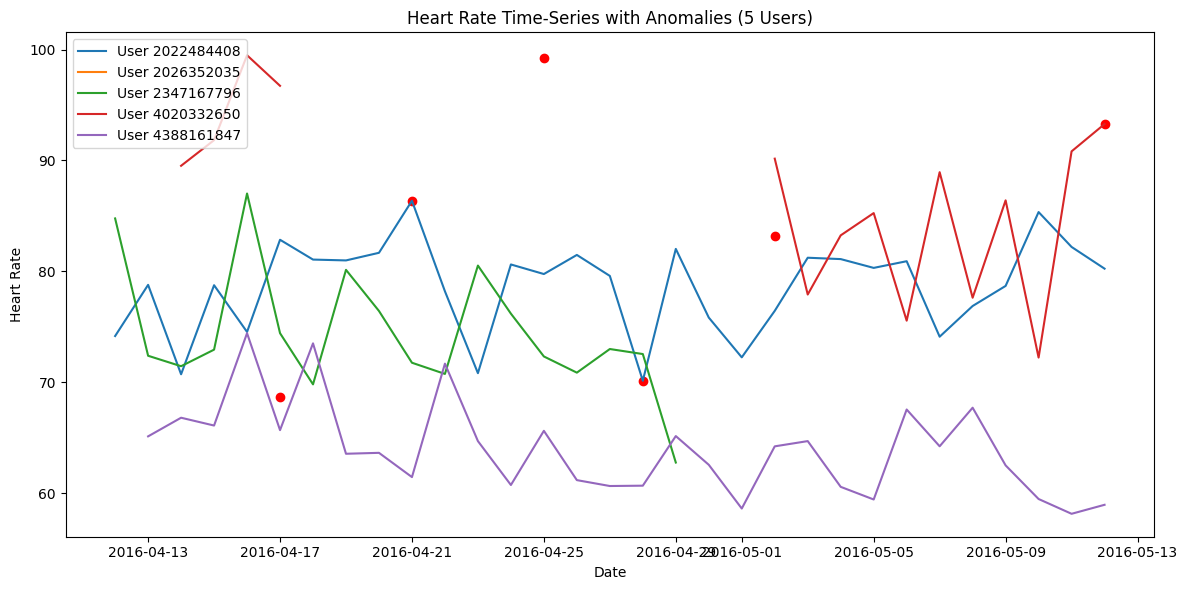

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


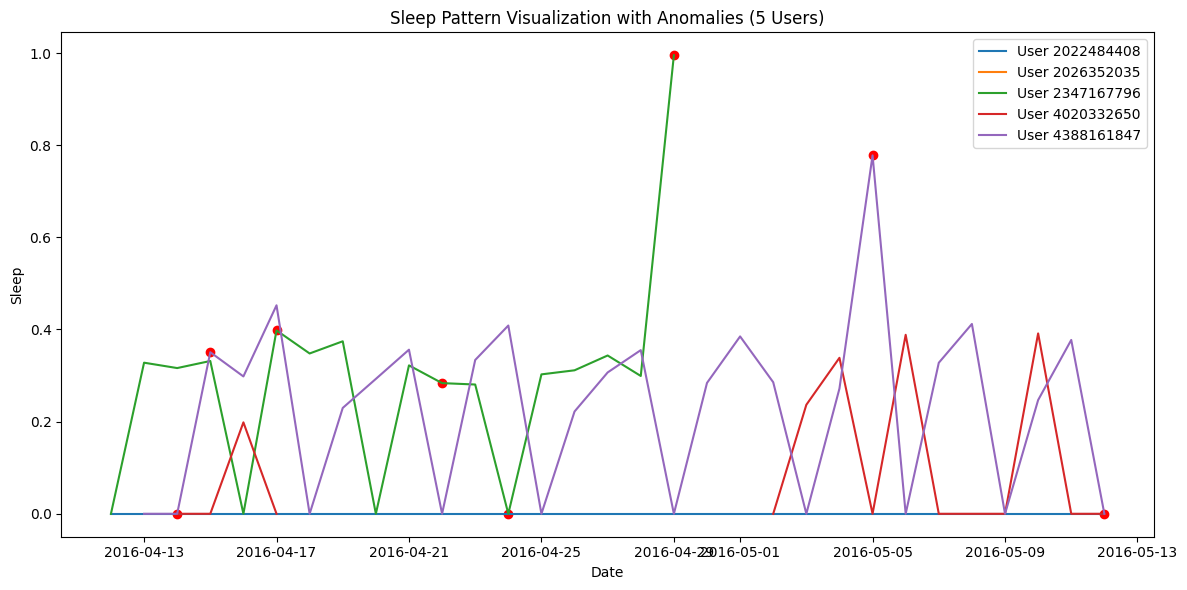

Milestone 3 anomaly detection completed successfully.
Screenshots saved in 'visualizations/' folder.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os

# Create visualization folder
os.makedirs("visualizations", exist_ok=True)

# Load cleaned dataset
df = pd.read_csv("/content/drive/MyDrive/FitPulse Health Anomaly Detection from Fitness Devices/Milestone2/data/cleaned_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.tz_localize(None)

# Select at least 5 users
user_ids = df["Id"].unique()[:5]

print("Selected User IDs:", user_ids)

# ANOMALY IDENTIFICATION (RESIDUAL ANALYSIS)


all_hr_results = []

for uid in user_ids:
    user_df = df[df["Id"] == uid]

    # -------- Heart Rate Data --------
    hr = user_df[["timestamp", "heart_rate"]].dropna()
    hr = hr.rename(columns={"timestamp": "ds", "heart_rate": "y"})
    hr = hr.set_index("ds").resample("D").mean().reset_index()

    if len(hr) < 10:
        continue

    # Prophet Model
    model = Prophet(daily_seasonality=True)
    model.fit(hr)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    # Residuals
    merged = hr.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged["residual"] = merged["y"] - merged["yhat"]
    merged["user_id"] = uid

    all_hr_results.append(merged)

# Combine all users
hr_results = pd.concat(all_hr_results, ignore_index=True)

# Threshold-based anomaly detection (Standard Deviation)

threshold_hr = 2 * hr_results["residual"].std()
hr_results["anomaly"] = abs(hr_results["residual"]) > threshold_hr

#ANOMALY LABELING

hr_results["label"] = hr_results["anomaly"].apply(
    lambda x: "Anomalous" if x else "Normal"
)

print("Sample labeled data:")
hr_results.head()

#VISUALIZATION OF HEART RATE ANOMALIES

plt.figure(figsize=(12,6))

for uid in user_ids:
    user_data = hr_results[hr_results["user_id"] == uid]
    plt.plot(user_data["ds"], user_data["y"], label=f"User {uid}")

    anomalies = user_data[user_data["anomaly"]]
    plt.scatter(anomalies["ds"], anomalies["y"], color="red")

plt.title("Heart Rate Time-Series with Anomalies (5 Users)")
plt.xlabel("Date")
plt.ylabel("Heart Rate")
plt.legend()
plt.tight_layout()

plt.savefig("visualizations/heart_rate_anomalies.png")
plt.show()

# ============================================================
# SLEEP ANOMALY DETECTION

all_sleep_results = []

for uid in user_ids:
    user_df = df[df["Id"] == uid]

    # -------- Sleep Data --------
    sleep = user_df[["timestamp", "sleep"]].dropna()
    sleep = sleep.rename(columns={"timestamp": "ds", "sleep": "y"})
    sleep = sleep.set_index("ds").resample("D").mean().reset_index()

    if len(sleep) < 10:
        continue

    model = Prophet(daily_seasonality=True)
    model.fit(sleep)

    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)

    merged = sleep.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    merged["residual"] = merged["y"] - merged["yhat"]
    merged["user_id"] = uid

    all_sleep_results.append(merged)

sleep_results = pd.concat(all_sleep_results, ignore_index=True)

# Threshold-based detection
threshold_sleep = 2 * sleep_results["residual"].std()
sleep_results["anomaly"] = abs(sleep_results["residual"]) > threshold_sleep

# ============================================================
# VISUALIZATION OF SLEEP ANOMALIES
# ============================================================

plt.figure(figsize=(12,6))

for uid in user_ids:
    user_data = sleep_results[sleep_results["user_id"] == uid]
    plt.plot(user_data["ds"], user_data["y"], label=f"User {uid}")

    anomalies = user_data[user_data["anomaly"]]
    plt.scatter(anomalies["ds"], anomalies["y"], color="red")

plt.title("Sleep Pattern Visualization with Anomalies (5 Users)")
plt.xlabel("Date")
plt.ylabel("Sleep")
plt.legend()
plt.tight_layout()

plt.savefig("visualizations/sleep_anomalies.png")
plt.show()
print("Milestone 3 anomaly detection completed successfully.")
print("Screenshots saved in 'visualizations/' folder.")